# pyRTC Example: Simulated Single Conjugate AO system with Pyramid Wavefront Sensor

This example will take you through how to set-up a basic SCAO system in pyRTC which uses the OOPAO simulation software to simulate the necessary AO hardware components.

### IMPORTANT NOTE BEFORE STARTING

**This notebook runs all of the AO components inside a single process. Because of the python Global Interpretter Lock, this will lead to SLOW performance, but will easier to debug. If you would like to run each computation as an independent process you will need to use the Hardware Launcher tool. Please see pywfs_example_OOPAO_pipeline.py for instructions** 

In [1]:
#Import the basics
import numpy as np
import yaml
import matplotlib.pyplot as plt

#Import hardware classes
from pyRTC.hardware.OOPAOInterface import OOPAOInterface
from pyRTC.SlopesProcess import SlopesProcess
# from pyRTC.Pipeline import *
from pyRTC.Loop import Loop

import time



     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             




In [2]:
"""
Shared memory in python is a bit annoying, we are required to unlink it from the garbage collector
so that it will stick around in between runs, however sometime you can get into a situation where 
the SHM is not intialized properly. Usually you will see an error like: 
TypeError: buffer is too small for requested array

To reset a SHM you can run the following code. Note: it will throw some garbage collector errors.
"""
# shm_names = ["wfs", "wfsRaw", "wfc", "wfc2D", "signal", "signal2D"] #list of SHMs to reset
# clear_shms(shm_names)

'\nShared memory in python is a bit annoying, we are required to unlink it from the garbage collector\nso that it will stick around in between runs, however sometime you can get into a situation where \nthe SHM is not intialized properly. Usually you will see an error like: \nTypeError: buffer is too small for requested array\n\nTo reset a SHM you can run the following code. Note: it will throw some garbage collector errors.\n'

pyRTC uses YAML config files to specify all of the variables for each component of your AO system. Setting up the config file properly is very important in order to have pyRTC run correctly.

For this example, we will be using the config file: pywfs_OOPAO_config.yaml

In [3]:
# Load the configuration file
def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        conf = yaml.safe_load(file)
    return conf

#Now we can read our YAML config file 
conf = read_yaml_file("pywfs_OOPAO_config.yaml")

#And separate it into sections for each of our AO loop components
confLoop = conf["loop"]
confWFS = conf["wfs"]
confWFC = conf["wfc"]
confPSF = conf["psf"]
confSlopes = conf["slopes"]

print(confLoop)
print(confWFS)
print(confWFC)
print(confPSF)
print(confSlopes)

{'gain': 0.1, 'numDroppedModes': 0, 'pokeAmp': 1e-06, 'numItersIM': 1, 'affinity': 2, 'method': 'push-pull', 'functions': ['standardIntegrator']}
{'name': 'OOPAOWFS', 'width': 48, 'height': 48, 'darkCount': 1000, 'affinity': 3, 'functions': ['expose']}
{'name': 'OOPAOWFC', 'numActuators': 356, 'numModes': 356, 'flatFile': '', 'saveFile': 'flat.npy', 'm2cFile': '', 'affinity': 3, 'commandCap': 0.8, 'hardwareDelay': 0.001, 'frameDelay': 0, 'functions': ['sendToHardware']}
{'name': 'OOPAOPSF', 'index': 0, 'width': 128, 'height': 128, 'darkCount': 1000, 'integration': 100, 'affinity': 3, 'functions': ['expose', 'integrate']}
{'type': 'PYWFS', 'signalType': 'slopes', 'affinity': 4, 'flatNorm': True, 'pupilsRadius': 12, 'pupils': ['12,12', '36,12', '12,36', '36,36'], 'functions': ['computeSignal']}


We have defined an OOPAO interface object which sets up an SCAO loop. This object is a wrapper for the following sub classes:

- _OOPAOScienceCamera
- _OOPAOSlopesProcess
- _OOPAOWFCorrector
- _OOPAOWFSensor

Each of these subclasses is a child of a pyRTC core class, which adds the interfacing and logic required by the OOPAO package. There are several core pyRTC classes, which each represent abstract versions of standard AO components. Some examples of pyRTC core classes include:

- WavefrontSensor
- WavefrontCorrector
- SlopesProcess
- ScienceCamera

The OOPAO interface is a wrapper for these objects which initializes them given the user provided configuration. Right now, this is limited to SCAO systems, but there is no reason that it could not be easily modified to support multiple wavefront sensors or correctors.

In [4]:
"""
Create the OOPAO simulation interface object 
Running this cell will initialize the dm, wfs, psf, and slopes objects, 
but will not start their real time computations. This inialization includes
the creation of the Shared Memory Objects, and the simulation inialization.
"""
sim = OOPAOInterface(conf=conf, param=None)
wfs, dm, psf = sim.get_hardware()

"""
It's important to set the full basis and number of possible modes before
initializing the loop object. Here I define a KL basis for the system
"""
from OOPAO.calibration.compute_KL_modal_basis import compute_KL_basis

NUM_MODES = 100

M2C_KL = compute_KL_basis(sim.tel, sim.atm, sim.dm)
dm.setM2C(M2C_KL[:,:NUM_MODES])

"""
"""
slopes = SlopesProcess(conf=conf)

""" 
"""
#Initialize our AO loop object
loop = Loop(conf=conf)


Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             8                [m]        
    Resolution            80             [pixels]     
    Pixel Size           0.1               [m]        
     Surface             50.0              [m2]       
Central Obstruction11.200000000000001 [% of diameter]  
Pixels in the pupil       4964            [pixels]     
  Field of View           0              [arcsec]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             8                [m]        
    Resolution            80             [pixels]     
    Pixel Size           0.1               [m]        
     Surface             50.0              

In [5]:
"""
Start the processes. Here the real-time computations selected in
the config will begin.
"""
dm.start()
dm.flatten()

wfs.start()
slopes.start()

print(sim.dm.OPD.shape)
psf.start()

Exception in thread Thread-44 (work):
Traceback (most recent call last):
  File "/home/donkeykong/anaconda3/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/home/donkeykong/anaconda3/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/home/donkeykong/anaconda3/lib/python3.11/site-packages/pyRTC/Pipeline.py", line 31, in work
    workFunction()
  File "/home/donkeykong/anaconda3/lib/python3.11/site-packages/pyRTC/hardware/OOPAOInterface.py", line 97, in expose
    self.tel.OPD = self.old_opd + self.dm.OPD#np.sum(self.dm.OPD, axis = 2)
                   ~~~~~~~~~~~~~^~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (80,80) (80,80,356) 


NameError: name 'sim' is not defined

### IMPORTANT: REAL-TIME VIEWING 

At this point, you can look at the shared memory objects to see what is happening in real time as we run the AO loop.

First, navigate on a terminal to the pyRTCView Folder: 

```cd INSTALLTION_LOCATION/pyRTC/pyRTCView```

Now run the viewer for whatever shared memory you would like to look at. For the default simulation run:

```
python pyRTCView.py wfs &
python pyRTCView.py wfc2D &
python pyRTCView.py signal2D &
python pyRTCView.py psfShort &
```

In [6]:
#Remove the atmosphere from the simulation
sim.removeAtmosphere()

loop.pokeAmp = 1e-7

#Compute the IM, blocking
loop.computeIM()

#Add the atmosphere back to the simulation
sim.addAtmosphere()

Telescope and Atmosphere separated!
Telescope and Atmosphere separated!


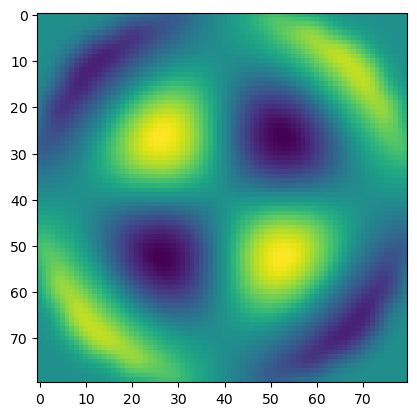

In [ ]:
plt.imshow(sim.dm.OPD)

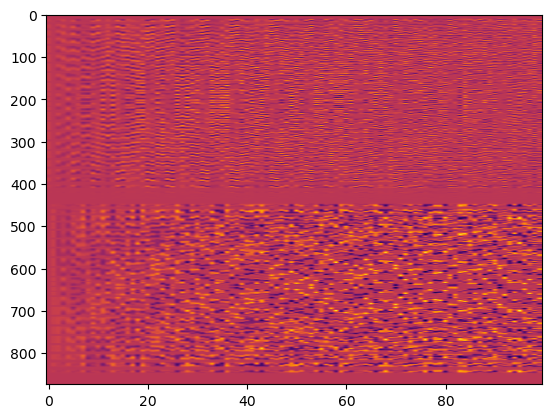

In [ ]:
loop.plotIM()

In [ ]:
dm.flatten()
time.sleep(1e-2)
loop.setGain(0.3)
loop.start()
time.sleep(10)
loop.stop()
dm.flatten()

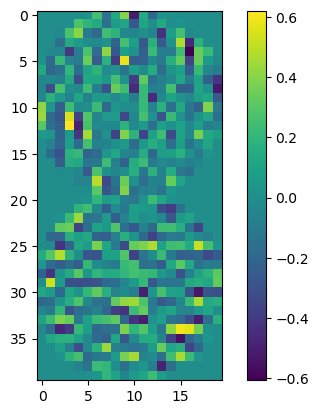

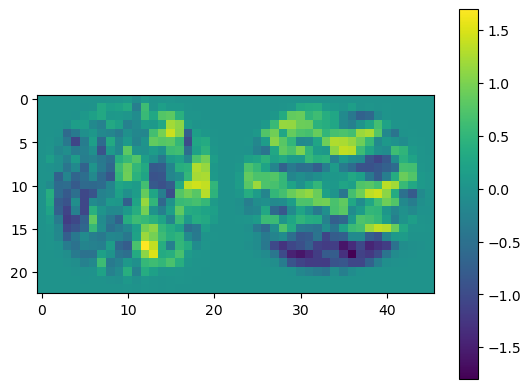

In [ ]:
plt.imshow(sim.wfs.signal_2D)
plt.colorbar()
plt.show()

plt.imshow(slopes.signal2D.read_noblock_safe())
plt.colorbar()
plt.show()

In [ ]:
sim.addAtmosphere()

Telescope and Atmosphere combined!
Telescope and Atmosphere combined!
